# Noise2Self for Neural Nets

This is a simple notebook demonstrating the principle of self-supervision to train denoising networks, together with napari for visualization of the training process.

For didactic purposes, we use a simple dataset (Gaussian noise on MNIST), a simple model (a small UNet), and a short training (100 iterations on a CPU). This notebook runs on a MacBook Pro in under one minute.

We start by launching the Jupyter/Qt integration for napari:

In [1]:
%gui qt

In [2]:
import os
os.environ['NAPARI_ASYNC'] = '1'

# Data

We demonstrate the use of a self-supervised denoising objective on a synthetically noised version of MNIST.

First, we load the data using torchvision's built-in MNIST tools:

In [3]:
import numpy as np

from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset

mnist_train = MNIST(
    'data/MNIST', 
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
    train=True
)

mnist_test = MNIST(
    'data/MNIST',
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
    train = False
)

Then we synthetically add high noise using `torch`:

In [4]:
from torch import randn

def add_noise(img):
    return img + randn(img.size())*0.4

class SyntheticNoiseDataset(Dataset):
    def __init__(self, data, mode='train'):
        self.mode = mode
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = self.data[index][0]
        return add_noise(img), img

In [5]:
noisy_mnist_train = SyntheticNoiseDataset(mnist_train, 'train')
noisy_mnist_test = SyntheticNoiseDataset(mnist_test, 'test')

We will try to learn to predict the clean image on the right *only* from the noisy image on the left.

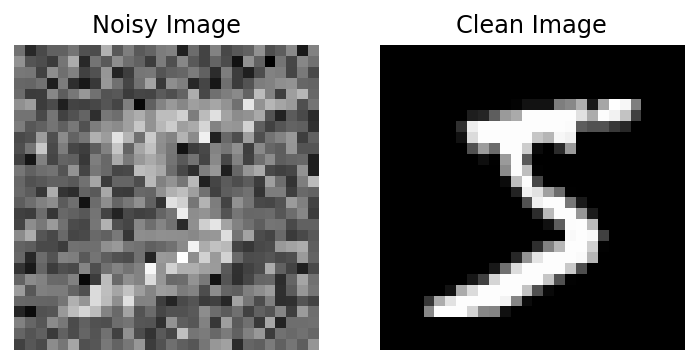

In [6]:
import matplotlib.pyplot as plt

noisy, clean = noisy_mnist_train[0]

fig, ax = plt.subplots(1, 2)

ax[0].imshow(noisy[0], cmap='gray')
ax[0].set_title('Noisy Image')
ax[0].set_axis_off()
ax[1].imshow(clean[0], cmap='gray')
ax[1].set_title('Clean Image')
ax[1].set_axis_off()

# Masking

The strategy is to train a $J$-invariant version of a neural net by replacing a grid of pixels with the average of their neighbors, then only evaluating the model on the masked pixels. Thus, we try to predict masked values from their surround — the masked pixels themselves contain none of their original information.

In [7]:
from mask import Masker
masker = Masker(width=4, mode='interpolate')

In [8]:
net_input, mask = masker.mask(noisy.unsqueeze(0), 0)

# Model

For our model, we use a short UNet with two levels of up- and down- sampling

In [9]:
from models.babyunet import BabyUnet
model = BabyUnet()

# Training

In [10]:
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader

loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Visualization

We lazily convert the torch tensors to NumPy arrays and concatenate them into dask arrays containing all the data. We do this for the training (noisy) data, the ground truth, and the model output.

There's a bit of reshaping because torch data comes with extra dimensions that we want to squeeze out, to only get a `(nsamples, size_y, size_x)` volume.

Finally, because of a [performance issue with `dask.array.stack`](https://github.com/dask/dask/issues/5913), we convert the input data to a non-lazy numpy array for the moment.

In [11]:
from dask import array as da, delayed

@delayed
def get_noisy_test_image(i):
    return (
        noisy_mnist_test[i][0].detach().numpy().reshape((28, 28))
    )

@delayed
def get_clean_test_image(i):
    return (
        noisy_mnist_test[i][1].detach().numpy().reshape((28, 28))
    )


noisy_test_dask = da.stack(
    [
        da.from_delayed(
            get_noisy_test_image(i),
            shape=(1, 28, 28),
            dtype=np.float32
        ).reshape((28, 28))
        for i in range(len(noisy_mnist_test))
    ]
)
noisy_test = np.array(noisy_test_dask)


clean_test_dask = da.stack(
    [
        da.from_delayed(
            get_clean_test_image(i),
            shape=(1, 28, 28),
            dtype=np.float32
        ).reshape((28, 28))
        for i in range(len(noisy_mnist_test))
    ]
)
clean_test = np.array(clean_test_dask)

We do the same for the output of our neural net model, but we don't convert to NumPy — we need to dynamically recompute this as the model is refined:

In [12]:
import torch

@delayed
def test_numpy_to_result_numpy(i):
    """Convert test NumPy array to model output and back to NumPy."""
    out = model(
        torch.Tensor(np.array(noisy_test_dask[i:i+1, np.newaxis]))
    ).detach().numpy().squeeze()
    return out

# build the results dask array
model_output_dask = da.stack(
    [
        da.from_delayed(
            test_numpy_to_result_numpy(i),
            shape=(28, 28),
            dtype=np.float32
        )
        for i in range(len(noisy_mnist_test))
    ]
)

We then build the napari viewer to see all three volumes simultaneously in grid view:

In [13]:
import napari


viewer = napari.Viewer()
_ = viewer.add_image(clean_test)  # returns layer, we don't care
_ = viewer.add_image(noisy_test)  # returns layer, we don't care
model_layer = viewer.add_image(
    model_output_dask,
    colormap='magma',
)  # this layer though, we're gonna play with
viewer.grid_view()

We turn off dask caching because we want the model to re-evaluate each time we view a model output.

In [14]:
from napari.utils import resize_dask_cache
resize_dask_cache(0)

We build a training loss plot. The dark style for matplotlib is a better fit for napari.

In [ ]:
from matplotlib.backends.backend_qt5agg import FigureCanvas
from matplotlib.figure import Figure

NUM_ITER = 100


# build the plot, but don't display it yet
# — we'll add it to the napari viewer later
with plt.style.context('dark_background'):
    loss_canvas = FigureCanvas(Figure(figsize=(5, 3)))
    loss_axes = loss_canvas.figure.subplots()
    lines = loss_axes.plot([], [])  # make empty plot
    loss_axes.set_xlim(0, NUM_ITER)
    loss_axes.set_xlabel('batch number')
    loss_axes.set_ylabel('loss')
    loss_canvas.figure.tight_layout()
    loss_line = lines[0]

Napari's threading utilities, created by Talley Lambert, allow *yielding* of values during a thread's execution, and connecting those yielded values to callbacks. Below, we create callbacks to update the loss plot and the displayed model output:

In [ ]:
# when getting a new loss, update the plot
def update_plot(loss):
    x, y = loss_line.get_data()
    new_y = np.append(y, loss)
    new_x = np.arange(len(new_y))
    loss_line.set_data(new_x, new_y)
    loss_axes.set_ylim(
        np.min(new_y) * (-0.05), np.max(new_y) * (1.05)
    )
    loss_canvas.draw()


# and update the model output layer
def update_viewer(loss):
    model_layer.refresh()
    viewer.help = f'loss: {loss}'

We then do two things to a standard PyTorch training loop:

- we wrap it in a function with the `@thread_worker` decorator
- inside the function, we yield the loss value after each training batch

In [ ]:
from napari.qt import thread_worker


# define a function to train the model in a new thread,
# connecting the yielded loss values to our update functions
@thread_worker(connect={'yielded': [update_viewer, update_plot]})
def train(model, data_loader, n_iter):

    for i, batch in zip(range(n_iter), data_loader):
        noisy_images, clean_images = batch

        net_input, mask = masker.mask(noisy_images, i)
        net_output = model(net_input)

        loss = loss_function(net_output*mask, noisy_images*mask)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        yield round(loss.item(), 4)

Finally, we create the PyTorch DataLoader, add the loss plot to our viewer, and start training! You should be able to see the model output refine over time, while simultaneously browsing through the whole test dataset.

In [ ]:
# finally, add the plot to the viewer, and start training!
data_loader = DataLoader(noisy_mnist_train, batch_size=32, shuffle=True)

viewer.window.add_dock_widget(loss_canvas)
worker = train(model, data_loader, NUM_ITER)

The final cell embeds the final state of the viewer for illustration only — for some yet-to-be-understood reason, *you should **NOT** run the cell until the training is finished*, or the whole update breaks.

In [ ]:
from napari.utils import nbscreenshot

nbscreenshot(viewer)